<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_2_0_v768_DreamBooth_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Dec  3 06:45:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## １．インストール



In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git
%pip install --upgrade diffusers[torch]
%pip install install -q accelerate==0.12.0  transformers ftfy bitsandbytes gradio natsort
!pip install --upgrade --pre triton
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-de2bcct8
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-de2bcct8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 29.2 MB/s 
  Created wheel for diffusers: filename=diffusers-0.10.0.dev0-py3-none-any.whl size=475150 sha256=82f8be1fd609efffc21dd39c1bb2bf7535d1542f14013d4feab144a13c4d66c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-6v5tv6g9/wheels/28/16/cf/d8d37579fd1e7edb978252d850ec9328b055a7582ddfae3b87
Successfully built diffusers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 191 kB 24.9 MB/s 
     |████████████████████████████████| 143 kB 40.1 

In [ ]:
!git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusers'...
remote: Enumerating objects: 14637, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 14637 (delta 110), reused 127 (delta 67), pack-reused 14455
Receiving objects: 100% (14637/14637), 10.02 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (10057/10057), done.


In [ ]:
%cd /content/diffusers/examples/dreambooth

/content/diffusers/examples/dreambooth


In [ ]:
# T4用にコンパイルされたバイナリを入れる。自分でコンパイルする場合は下段をコメントアウト。その場合30分以上はかかります。
# ShivamShriraoさんのColab( https://github.com/ShivamShrirao/)より引用
%pip install -q https://github.com/ShivamShrirao/xformers-wheels/releases/download/4c06c79/xformers-0.0.15.dev0+4c06c79.d20221201-cp38-cp38-linux_x86_64.whl
# !pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 113.2 MB 1.9 MB/s 


## ２．huggingfaceにLogin

In [ ]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## ３．モデルのダウンロード

In [ ]:
!git lfs install
!git clone https://huggingface.co/stabilityai/stable-diffusion-2
MODEL_NAME = "stable-diffusion-2"

# stable-diffusion-2を単に動かしてみたい方は６．画像生成に進んでください

Updated git hooks.
Git LFS initialized.
Cloning into 'stable-diffusion-2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 138 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (138/138), 601.46 KiB | 665.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.
tcmalloc: large alloc 1471086592 bytes == 0x5580e6842000 @  0x7f0676a6c2a4 0x5580a999578f 0x5580a99728db 0x5580a99275b3 0x5580a98cb34a 0x5580a98cb806 0x5580a98e8ad1 0x5580a98e9069 0x5580a98e9593 0x5580a998e482 0x5580a982ecc2 0x5580a9815a75 0x5580a9816735 0x5580a981573a 0x7f0675db3c87 0x5580a981578a
tcmalloc: large alloc 1471086592 bytes == 0x5580e6842000 @  0x7f0676a6c2a4 0x5580a999578f 0x5580a99728db 0x5580a99275b3 0x5580a98cb34a 0x5580a98cb806 0x5580a98e8ad1 0x5580a98e9069 0x5580a98e9593 0x5580a998e482 0x5580a982ecc2 0x5580a9815a75 0x5580a9816735 0x5580a981573a 0x7f0675db3c87 0x5580a981578a
tcmalloc: larg

## ４．学習用画像のアップロード

In [ ]:
INSTANCE_DIR = "/content/data/instance-images"
!mkdir -p $INSTANCE_DIR
CLASS_NAME="dog"
CLASS_DIR = f"/content/data/{CLASS_NAME}"

# モデルが出来る場所
# 出来たモデルを保存しておけば後日再利用する事ができます。
OUTPUT_DIR = "/content/models/dreambooth_model"

In [ ]:
# INSTANCE_DIRに画像を保存
# 犬の画像の例なので愛犬の画像を３～５枚程度アップロードしてください。猫が良い場合は上のセルのCLASS_NAMEをcatにしてください。
import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    print(f'move {filename} to {dst_path}')
    shutil.move(filename, dst_path)

Saving 256-doge1.png to 256-doge1.png
Saving 256-doge2.png to 256-doge2.png
Saving 256-doge3.png to 256-doge3.png
Saving 256-doge4.png to 256-doge4.png
Saving 256-doge5.png to 256-doge5.png
Saving 256-doge6.png to 256-doge6.png
Saving 256-doge7.png to 256-doge7.png
move 256-doge1.png to /content/data/instance-images/256-doge1.png
move 256-doge2.png to /content/data/instance-images/256-doge2.png
move 256-doge3.png to /content/data/instance-images/256-doge3.png
move 256-doge4.png to /content/data/instance-images/256-doge4.png
move 256-doge5.png to /content/data/instance-images/256-doge5.png
move 256-doge6.png to /content/data/instance-images/256-doge6.png
move 256-doge7.png to /content/data/instance-images/256-doge7.png


## ５．DreamBooth拡張の実行

In [ ]:
# トレーニングには約1時間10分かかります。
# qwzは既存の実体と被らなければ何でも良いです。
# 良く使われるsksは銃の名前とバッティングするので良くないとされています
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="Photo of qwz dog" \
  --class_prompt="Photo of dog" \
  --resolution=768\
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 --gradient_checkpointing \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=10 \
  --sample_batch_size=1 \
  --max_train_steps=800 \
  --use_8bit_adam \
  --mixed_precision="fp16" 

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  

## ６．画像生成

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

  0%|          | 0/50 [00:00<?, ?it/s]

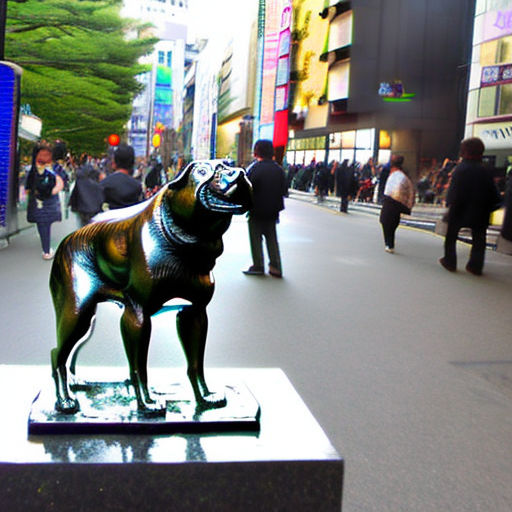

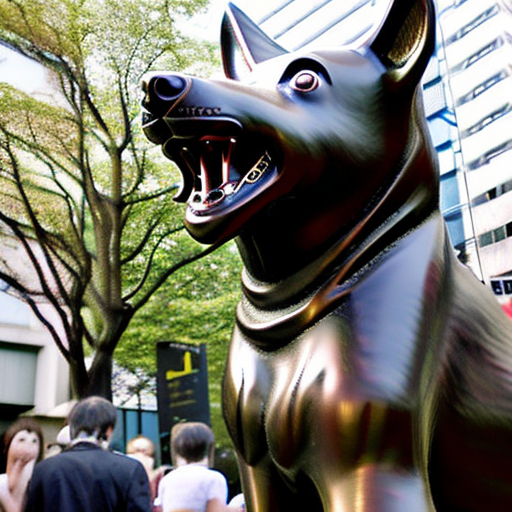

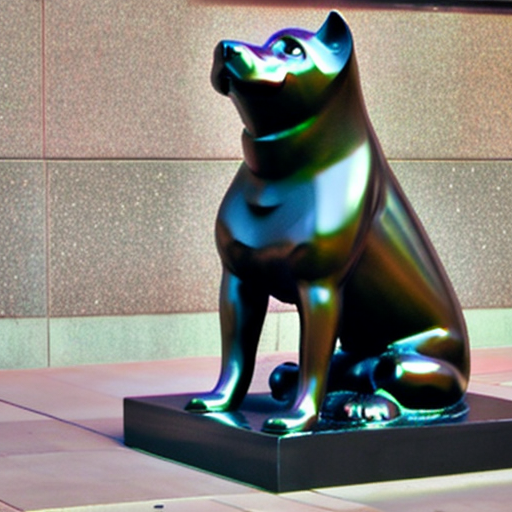

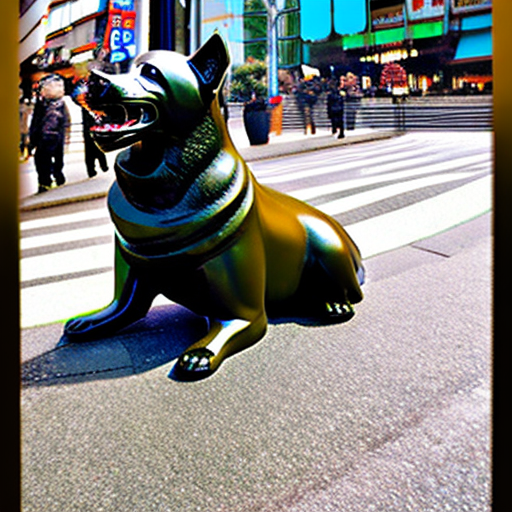

In [ ]:
batch_size = 4

prompt = ["Photo of Bronze statue of qwz dog in Shibuya"] * batch_size

g_cuda = torch.Generator(device='cuda')
pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, torch_dtype=torch.float16).to("cuda")

with autocast("cuda"), torch.no_grad():
    images = pipe(prompt, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, generator=g_cuda).images

for img in images:
    display(img)